In [1]:
import os
import pandas
import matplotlib.pyplot as plt
import seaborn
from tqdm import tqdm
import numpy as np

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms

In [2]:
class CNN_Mnist(nn.Module):
    def __init__(self):
        super(CNN_Mnist, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64*7*7, 16),
            nn.ReLU(),
        )

        self.z_mean = nn.Linear(16, 2)
        self.z_log_var = nn.Linear(16, 2)

        self.decoder = nn.Sequential(
            nn.Linear(2, 64*7*7),
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        enc = self.encoder(x)
        mu = self.z_mean(enc)
        lv = self.z_log_var(enc)
        lat = self.reparam(mu, lv)
        dec = self.decoder(lat)
        
        return dec, mu, lv

    def reparam(self, mu, lv):
        std = torch.exp(0.5 * lv)
        eps = torch.randn_like(std)
        return mu + std * eps

In [3]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

trainset = MNIST(root='~/data', train=True, download=True, transform=transform)
train_dl = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=24)
testset = MNIST(root='~/data', train=False, download=True, transform=transform)
test_dl = DataLoader(testset, batch_size=128, shuffle=False, num_workers=24)

print(len(trainset), len(testset))
print(len(train_dl), len(test_dl))

60000 10000
469 79


In [4]:
def gaussian_kls(mu, logvar):
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
    return torch.mean(kld_loss)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 0)

model = CNN_Mnist().to(device)

optimizer = Adam(params = model.parameters(), lr = 0.001)

epochs = 100

scheduler = CosineAnnealingLR(optimizer, epochs*len(train_dl))

recon_loss = nn.MSELoss(reduction='none')

def loss_fn(recon_x, x):
    return torch.mean(torch.sum(recon_loss(recon_x, x), dim=(1,2,3)))

In [6]:
for epoch in range(epochs):
    model.train()
    tr_total_loss = {
        "rec_loss" : 0,
        "kl_loss" : 0
    }
    for train_img, _ in tqdm(train_dl):
        train_img = train_img.to(device)

        gen_img, train_mu, train_lv = model(train_img)
        train_rec_loss = loss_fn(gen_img, train_img)
        train_kl_loss = gaussian_kls(train_mu, train_lv)
        train_loss = train_rec_loss + train_kl_loss

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        scheduler.step()

        tr_total_loss["rec_loss"] += train_rec_loss.item()
        tr_total_loss["kl_loss"] += train_kl_loss.item()

    model.eval()
    with torch.no_grad():
        va_total_loss = {
            "rec_loss" : 0,
            "kl_loss" : 0
        }
        for valid_img, _ in tqdm(test_dl):
            valid_img = valid_img.to(device)

            gen_img, valid_mu, valid_lv = model(valid_img)
            valid_rec_loss = loss_fn(gen_img, valid_img)
            valid_kl_loss = gaussian_kls(valid_mu, valid_lv)
            valid_loss = valid_rec_loss + valid_kl_loss

            va_total_loss["rec_loss"] += valid_rec_loss.item()
            va_total_loss["kl_loss"] += valid_kl_loss.item()

    print(f"Epoch: {epoch} - TrainRecLoss: {tr_total_loss['rec_loss']/len(train_dl)} - ValidRecLoss: {va_total_loss['rec_loss']/len(test_dl)}")
    print(f"Epoch: {epoch} - TrainDivLoss: {tr_total_loss['kl_loss']/len(train_dl)} - ValidDivLoss: {va_total_loss['kl_loss']/len(test_dl)}")

100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 66.23it/s]


Epoch: 0 - TrainRecLoss: 47.962819748087476 - ValidRecLoss: 41.46605049809323
Epoch: 0 - TrainDivLoss: 2.320888367352455 - ValidDivLoss: 2.995955935007409


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 64.03it/s]


Epoch: 1 - TrainRecLoss: 40.14718958157212 - ValidRecLoss: 39.29180782656126
Epoch: 1 - TrainDivLoss: 3.142649504167439 - ValidDivLoss: 3.2853686477564557


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 64.95it/s]


Epoch: 2 - TrainRecLoss: 38.55041372953956 - ValidRecLoss: 38.02406591101538
Epoch: 2 - TrainDivLoss: 3.469622037558159 - ValidDivLoss: 3.548292344129538


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 64.42it/s]


Epoch: 3 - TrainRecLoss: 37.544386410255676 - ValidRecLoss: 37.14051490493968
Epoch: 3 - TrainDivLoss: 3.6794905255852477 - ValidDivLoss: 3.80356471448005


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 65.82it/s]


Epoch: 4 - TrainRecLoss: 36.69561007892145 - ValidRecLoss: 36.37994198859492
Epoch: 4 - TrainDivLoss: 3.8406244152898728 - ValidDivLoss: 3.8761444333233412


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 63.60it/s]


Epoch: 5 - TrainRecLoss: 36.10176451628142 - ValidRecLoss: 35.774904033805754
Epoch: 5 - TrainDivLoss: 3.955315063248819 - ValidDivLoss: 4.054721527461764


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 63.68it/s]


Epoch: 6 - TrainRecLoss: 35.63693315388043 - ValidRecLoss: 35.75159630594374
Epoch: 6 - TrainDivLoss: 4.068669994756865 - ValidDivLoss: 3.9392253205746033


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 64.33it/s]


Epoch: 7 - TrainRecLoss: 35.195445449113336 - ValidRecLoss: 35.22971768922444
Epoch: 7 - TrainDivLoss: 4.148945272604285 - ValidDivLoss: 4.288611701772183


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 67.42it/s]


Epoch: 8 - TrainRecLoss: 34.91237092984002 - ValidRecLoss: 34.923458244227156
Epoch: 8 - TrainDivLoss: 4.210238209665457 - ValidDivLoss: 4.3444295653814


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 65.62it/s]


Epoch: 9 - TrainRecLoss: 34.620904495467 - ValidRecLoss: 34.65403897249246
Epoch: 9 - TrainDivLoss: 4.288690952349827 - ValidDivLoss: 4.264759887622882


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 63.68it/s]


Epoch: 10 - TrainRecLoss: 34.3958254775513 - ValidRecLoss: 34.44612944880618
Epoch: 10 - TrainDivLoss: 4.340615582618632 - ValidDivLoss: 4.279802648327019


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 63.15it/s]


Epoch: 11 - TrainRecLoss: 34.157249332745195 - ValidRecLoss: 34.264859211595756
Epoch: 11 - TrainDivLoss: 4.374257225980128 - ValidDivLoss: 4.319649823104279


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 62.04it/s]


Epoch: 12 - TrainRecLoss: 33.99292981650021 - ValidRecLoss: 34.01271402383153
Epoch: 12 - TrainDivLoss: 4.4176647373354 - ValidDivLoss: 4.5096888723252695


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 63.46it/s]


Epoch: 13 - TrainRecLoss: 33.83419212552784 - ValidRecLoss: 33.74230908743943
Epoch: 13 - TrainDivLoss: 4.442023581279112 - ValidDivLoss: 4.520092426976071


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 65.14it/s]


Epoch: 14 - TrainRecLoss: 33.67111742877757 - ValidRecLoss: 33.830593060843555
Epoch: 14 - TrainDivLoss: 4.485300595826431 - ValidDivLoss: 4.48400192622897


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 65.30it/s]


Epoch: 15 - TrainRecLoss: 33.54830039132124 - ValidRecLoss: 33.778843577904034
Epoch: 15 - TrainDivLoss: 4.518337638139216 - ValidDivLoss: 4.447132913372185


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 67.30it/s]


Epoch: 16 - TrainRecLoss: 33.433942705329294 - ValidRecLoss: 33.517476456074775
Epoch: 16 - TrainDivLoss: 4.539462200360004 - ValidDivLoss: 4.568799948390526


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 64.49it/s]


Epoch: 17 - TrainRecLoss: 33.281047353358154 - ValidRecLoss: 33.50110998032968
Epoch: 17 - TrainDivLoss: 4.564902745838612 - ValidDivLoss: 4.594913639599764


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 63.38it/s]


Epoch: 18 - TrainRecLoss: 33.199194780036585 - ValidRecLoss: 33.55625309521639
Epoch: 18 - TrainDivLoss: 4.590547568762481 - ValidDivLoss: 4.472013624408577


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 63.42it/s]


Epoch: 19 - TrainRecLoss: 33.088189964863794 - ValidRecLoss: 33.33298311354239
Epoch: 19 - TrainDivLoss: 4.612634735066753 - ValidDivLoss: 4.61949830115596


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 63.29it/s]


Epoch: 20 - TrainRecLoss: 32.99058233801998 - ValidRecLoss: 33.15516157995297
Epoch: 20 - TrainDivLoss: 4.614933644276438 - ValidDivLoss: 4.651317662830595


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 64.85it/s]


Epoch: 21 - TrainRecLoss: 32.93282687384437 - ValidRecLoss: 33.33852169181727
Epoch: 21 - TrainDivLoss: 4.646616006456712 - ValidDivLoss: 4.543300580374802


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 64.04it/s]


Epoch: 22 - TrainRecLoss: 32.833555469634945 - ValidRecLoss: 33.1074424695365
Epoch: 22 - TrainDivLoss: 4.6640222606374255 - ValidDivLoss: 4.628853429721881


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 65.10it/s]


Epoch: 23 - TrainRecLoss: 32.76896857401964 - ValidRecLoss: 33.34341932852057
Epoch: 23 - TrainDivLoss: 4.678482284423893 - ValidDivLoss: 4.471808687041078


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 64.60it/s]


Epoch: 24 - TrainRecLoss: 32.70275201370467 - ValidRecLoss: 33.01152480403079
Epoch: 24 - TrainDivLoss: 4.676149825805794 - ValidDivLoss: 4.653014321870442


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 67.89it/s]


Epoch: 25 - TrainRecLoss: 32.62316238956411 - ValidRecLoss: 33.10022856313971
Epoch: 25 - TrainDivLoss: 4.7043725391949165 - ValidDivLoss: 4.588084637364255


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 64.61it/s]


Epoch: 26 - TrainRecLoss: 32.54761074041761 - ValidRecLoss: 32.99930823603763
Epoch: 26 - TrainDivLoss: 4.721813029063536 - ValidDivLoss: 4.7675999750064895


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 64.81it/s]


Epoch: 27 - TrainRecLoss: 32.49292131273477 - ValidRecLoss: 32.88174798217001
Epoch: 27 - TrainDivLoss: 4.725936941500666 - ValidDivLoss: 4.839886598949191


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 65.05it/s]


Epoch: 28 - TrainRecLoss: 32.44047841232723 - ValidRecLoss: 33.07769331147399
Epoch: 28 - TrainDivLoss: 4.75237773476379 - ValidDivLoss: 4.644796051556551


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 60.92it/s]


Epoch: 29 - TrainRecLoss: 32.38952330078906 - ValidRecLoss: 32.745225858084765
Epoch: 29 - TrainDivLoss: 4.753834379761458 - ValidDivLoss: 4.862172434601603


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 62.03it/s]


Epoch: 30 - TrainRecLoss: 32.32007869728593 - ValidRecLoss: 32.99964349481124
Epoch: 30 - TrainDivLoss: 4.763395463988217 - ValidDivLoss: 4.661232103275347


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 63.67it/s]


Epoch: 31 - TrainRecLoss: 32.25479674593472 - ValidRecLoss: 32.704421272760705
Epoch: 31 - TrainDivLoss: 4.775703082460838 - ValidDivLoss: 4.800740097142473


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 66.63it/s]


Epoch: 32 - TrainRecLoss: 32.214330726086715 - ValidRecLoss: 32.60112603103058
Epoch: 32 - TrainDivLoss: 4.791064629422576 - ValidDivLoss: 4.962346191647686


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 66.22it/s]


Epoch: 33 - TrainRecLoss: 32.14899375850458 - ValidRecLoss: 32.81750114054619
Epoch: 33 - TrainDivLoss: 4.797951428874978 - ValidDivLoss: 4.711945509608788


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 64.95it/s]


Epoch: 34 - TrainRecLoss: 32.11862732454149 - ValidRecLoss: 32.66386551193044
Epoch: 34 - TrainDivLoss: 4.802285137461193 - ValidDivLoss: 4.80690236634846


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 65.17it/s]


Epoch: 35 - TrainRecLoss: 32.07499635855018 - ValidRecLoss: 33.12266352206846
Epoch: 35 - TrainDivLoss: 4.813786688643987 - ValidDivLoss: 4.625250912919829


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 62.83it/s]


Epoch: 36 - TrainRecLoss: 32.03095059506675 - ValidRecLoss: 32.72483065158506
Epoch: 36 - TrainDivLoss: 4.827261243547712 - ValidDivLoss: 4.758339803430099


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 61.86it/s]


Epoch: 37 - TrainRecLoss: 31.966782832196525 - ValidRecLoss: 32.69189168229888
Epoch: 37 - TrainDivLoss: 4.832519687823395 - ValidDivLoss: 4.744697220717804


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 64.37it/s]


Epoch: 38 - TrainRecLoss: 31.930551256452286 - ValidRecLoss: 32.58794188197655
Epoch: 38 - TrainDivLoss: 4.835135152853374 - ValidDivLoss: 4.810837395583527


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 62.62it/s]


Epoch: 39 - TrainRecLoss: 31.893427667841475 - ValidRecLoss: 32.61412050754209
Epoch: 39 - TrainDivLoss: 4.846706382247176 - ValidDivLoss: 4.851309070104285


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 64.92it/s]


Epoch: 40 - TrainRecLoss: 31.85016243696721 - ValidRecLoss: 32.503700980657264
Epoch: 40 - TrainDivLoss: 4.858522438545471 - ValidDivLoss: 4.827759615982635


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 66.49it/s]


Epoch: 41 - TrainRecLoss: 31.805500197258077 - ValidRecLoss: 32.45839024797271
Epoch: 41 - TrainDivLoss: 4.855300454951045 - ValidDivLoss: 4.868353403067287


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 65.54it/s]


Epoch: 42 - TrainRecLoss: 31.78726095024711 - ValidRecLoss: 32.6069700506669
Epoch: 42 - TrainDivLoss: 4.872331619262695 - ValidDivLoss: 4.721905014182948


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 64.74it/s]


Epoch: 43 - TrainRecLoss: 31.730038685585136 - ValidRecLoss: 32.45386606530298
Epoch: 43 - TrainDivLoss: 4.87878491680251 - ValidDivLoss: 4.872690224949317


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 63.24it/s]


Epoch: 44 - TrainRecLoss: 31.68686515791838 - ValidRecLoss: 32.38057179994221
Epoch: 44 - TrainDivLoss: 4.879724298204694 - ValidDivLoss: 4.868518968171712


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 64.07it/s]


Epoch: 45 - TrainRecLoss: 31.648231941499688 - ValidRecLoss: 32.36926182614097
Epoch: 45 - TrainDivLoss: 4.893391535988749 - ValidDivLoss: 4.907579228847841


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 65.04it/s]


Epoch: 46 - TrainRecLoss: 31.61326953749667 - ValidRecLoss: 32.35288540321061
Epoch: 46 - TrainDivLoss: 4.892920026392825 - ValidDivLoss: 4.864843157273304


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 65.10it/s]


Epoch: 47 - TrainRecLoss: 31.590034383192247 - ValidRecLoss: 32.463345394858834
Epoch: 47 - TrainDivLoss: 4.902680781350207 - ValidDivLoss: 4.87411972842639


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 66.51it/s]


Epoch: 48 - TrainRecLoss: 31.546242581755877 - ValidRecLoss: 32.27556849129592
Epoch: 48 - TrainDivLoss: 4.909877330763762 - ValidDivLoss: 4.891992055917088


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 69.30it/s]


Epoch: 49 - TrainRecLoss: 31.530519343134184 - ValidRecLoss: 32.392722842059555
Epoch: 49 - TrainDivLoss: 4.9134691671521935 - ValidDivLoss: 4.9024520282503925


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 65.92it/s]


Epoch: 50 - TrainRecLoss: 31.477619508690417 - ValidRecLoss: 32.269825005833106
Epoch: 50 - TrainDivLoss: 4.9150109779097635 - ValidDivLoss: 4.882229792920849


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 69.30it/s]


Epoch: 51 - TrainRecLoss: 31.47019191083115 - ValidRecLoss: 32.32640949683854
Epoch: 51 - TrainDivLoss: 4.923285500581331 - ValidDivLoss: 4.790876026395001


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 67.13it/s]


Epoch: 52 - TrainRecLoss: 31.428399974603387 - ValidRecLoss: 32.190468051765535
Epoch: 52 - TrainDivLoss: 4.920797925513945 - ValidDivLoss: 4.975047926359538


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 69.42it/s]


Epoch: 53 - TrainRecLoss: 31.401053638092236 - ValidRecLoss: 32.18895868711834
Epoch: 53 - TrainDivLoss: 4.936984918264947 - ValidDivLoss: 4.9688930028601535


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 67.00it/s]


Epoch: 54 - TrainRecLoss: 31.369927546617063 - ValidRecLoss: 32.31314432168309
Epoch: 54 - TrainDivLoss: 4.922289913397099 - ValidDivLoss: 4.859455923490886


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 69.00it/s]


Epoch: 55 - TrainRecLoss: 31.33388517660373 - ValidRecLoss: 32.26604604117478
Epoch: 55 - TrainDivLoss: 4.9374788880094025 - ValidDivLoss: 4.879796329932876


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 69.48it/s]


Epoch: 56 - TrainRecLoss: 31.316033959134554 - ValidRecLoss: 32.17107415501076
Epoch: 56 - TrainDivLoss: 4.931452460380505 - ValidDivLoss: 4.9506601623342


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 69.49it/s]


Epoch: 57 - TrainRecLoss: 31.27783523592105 - ValidRecLoss: 32.22693119773382
Epoch: 57 - TrainDivLoss: 4.957875136881749 - ValidDivLoss: 4.876568703711787


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 68.67it/s]


Epoch: 58 - TrainRecLoss: 31.262590518129915 - ValidRecLoss: 32.20513773568069
Epoch: 58 - TrainDivLoss: 4.947148366777627 - ValidDivLoss: 4.922570107858392


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 67.77it/s]


Epoch: 59 - TrainRecLoss: 31.24159991054901 - ValidRecLoss: 32.1702992161618
Epoch: 59 - TrainDivLoss: 4.942756304100378 - ValidDivLoss: 4.959900010990191


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 65.86it/s]


Epoch: 60 - TrainRecLoss: 31.210289656226315 - ValidRecLoss: 32.13402793980852
Epoch: 60 - TrainDivLoss: 4.974482596301829 - ValidDivLoss: 4.952735170533385


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 67.75it/s]


Epoch: 61 - TrainRecLoss: 31.18373731763632 - ValidRecLoss: 32.20937301539168
Epoch: 61 - TrainDivLoss: 4.960591498214299 - ValidDivLoss: 4.91875177093699


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 68.23it/s]


Epoch: 62 - TrainRecLoss: 31.156492192607953 - ValidRecLoss: 32.21153010597712
Epoch: 62 - TrainDivLoss: 4.967570817292626 - ValidDivLoss: 4.866237905961048


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 68.24it/s]


Epoch: 63 - TrainRecLoss: 31.14358875949754 - ValidRecLoss: 32.098414940170095
Epoch: 63 - TrainDivLoss: 4.979745588322946 - ValidDivLoss: 4.982200000859514


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 66.80it/s]


Epoch: 64 - TrainRecLoss: 31.113898332185073 - ValidRecLoss: 32.22705925567241
Epoch: 64 - TrainDivLoss: 4.970330305445168 - ValidDivLoss: 4.854956053480318


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 67.21it/s]


Epoch: 65 - TrainRecLoss: 31.093389421637887 - ValidRecLoss: 32.00596816630303
Epoch: 65 - TrainDivLoss: 4.97880112540239 - ValidDivLoss: 5.004532928708233


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 65.92it/s]


Epoch: 66 - TrainRecLoss: 31.061106236504592 - ValidRecLoss: 32.12012517904933
Epoch: 66 - TrainDivLoss: 4.982655471321871 - ValidDivLoss: 4.924504358557206


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 67.18it/s]


Epoch: 67 - TrainRecLoss: 31.043600607020007 - ValidRecLoss: 32.06373441672023
Epoch: 67 - TrainDivLoss: 4.985628666908248 - ValidDivLoss: 4.985358618482759


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 66.70it/s]


Epoch: 68 - TrainRecLoss: 31.02753152420272 - ValidRecLoss: 32.118381669249715
Epoch: 68 - TrainDivLoss: 4.99191501044007 - ValidDivLoss: 4.888138433045979


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 67.12it/s]


Epoch: 69 - TrainRecLoss: 31.00209554578704 - ValidRecLoss: 32.05458269239981
Epoch: 69 - TrainDivLoss: 4.990418185049029 - ValidDivLoss: 4.910047935534127


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 68.48it/s]


Epoch: 70 - TrainRecLoss: 30.994734070702656 - ValidRecLoss: 32.022872031489506
Epoch: 70 - TrainDivLoss: 5.006818429747624 - ValidDivLoss: 5.029834668847579


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 67.86it/s]


Epoch: 71 - TrainRecLoss: 30.97055766221557 - ValidRecLoss: 32.020065524910066
Epoch: 71 - TrainDivLoss: 4.995510993990054 - ValidDivLoss: 4.975718244721618


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 68.46it/s]


Epoch: 72 - TrainRecLoss: 30.94864936373127 - ValidRecLoss: 31.974167811719678
Epoch: 72 - TrainDivLoss: 5.009125232696533 - ValidDivLoss: 5.014895167531846


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 68.10it/s]


Epoch: 73 - TrainRecLoss: 30.944919423507983 - ValidRecLoss: 32.00440148462223
Epoch: 73 - TrainDivLoss: 5.023184319803201 - ValidDivLoss: 4.994484213334095


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 68.45it/s]


Epoch: 74 - TrainRecLoss: 30.922339229949756 - ValidRecLoss: 32.00677294670781
Epoch: 74 - TrainDivLoss: 5.011788518698231 - ValidDivLoss: 4.97883683820314


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 68.85it/s]


Epoch: 75 - TrainRecLoss: 30.915219849869132 - ValidRecLoss: 32.03459894204442
Epoch: 75 - TrainDivLoss: 5.011331506375311 - ValidDivLoss: 4.996595376654517


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 66.69it/s]


Epoch: 76 - TrainRecLoss: 30.88885435417517 - ValidRecLoss: 31.948679887795752
Epoch: 76 - TrainDivLoss: 5.01679286062082 - ValidDivLoss: 5.023192598849913


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 68.38it/s]


Epoch: 77 - TrainRecLoss: 30.880472569577474 - ValidRecLoss: 32.00776983816412
Epoch: 77 - TrainDivLoss: 5.018644688734367 - ValidDivLoss: 4.997339544416983


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 66.32it/s]


Epoch: 78 - TrainRecLoss: 30.853843888240075 - ValidRecLoss: 31.947135442419896
Epoch: 78 - TrainDivLoss: 5.0179754523580264 - ValidDivLoss: 5.013724538344372


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 65.47it/s]


Epoch: 79 - TrainRecLoss: 30.85036858922637 - ValidRecLoss: 31.9822293293627
Epoch: 79 - TrainDivLoss: 5.014117731976865 - ValidDivLoss: 5.0200933504708205


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 68.15it/s]


Epoch: 80 - TrainRecLoss: 30.835792850583854 - ValidRecLoss: 31.93218817891954
Epoch: 80 - TrainDivLoss: 5.016675820991175 - ValidDivLoss: 5.029838833627822


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 67.75it/s]


Epoch: 81 - TrainRecLoss: 30.823660624815204 - ValidRecLoss: 31.8844537131394
Epoch: 81 - TrainDivLoss: 5.020205308633573 - ValidDivLoss: 5.0180471154707895


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 68.75it/s]


Epoch: 82 - TrainRecLoss: 30.810787493740317 - ValidRecLoss: 31.984917966625357
Epoch: 82 - TrainDivLoss: 5.0269366520554275 - ValidDivLoss: 4.992916565907152


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 68.90it/s]


Epoch: 83 - TrainRecLoss: 30.80955182870568 - ValidRecLoss: 31.8988853164866
Epoch: 83 - TrainDivLoss: 5.0196570018207085 - ValidDivLoss: 5.014735318437407


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 66.24it/s]


Epoch: 84 - TrainRecLoss: 30.790564034793423 - ValidRecLoss: 31.98729877230487
Epoch: 84 - TrainDivLoss: 5.02328577732989 - ValidDivLoss: 4.989351622665985


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 66.39it/s]


Epoch: 85 - TrainRecLoss: 30.77954005178358 - ValidRecLoss: 31.938408525684213
Epoch: 85 - TrainDivLoss: 5.0243413117902875 - ValidDivLoss: 4.991980450062812


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 66.77it/s]


Epoch: 86 - TrainRecLoss: 30.782830752797725 - ValidRecLoss: 31.867661946936497
Epoch: 86 - TrainDivLoss: 5.03265930798008 - ValidDivLoss: 5.027078127559228


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 67.99it/s]


Epoch: 87 - TrainRecLoss: 30.768506483228474 - ValidRecLoss: 31.91118223455888
Epoch: 87 - TrainDivLoss: 5.03499443342945 - ValidDivLoss: 5.009537153606173


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 68.36it/s]


Epoch: 88 - TrainRecLoss: 30.767297996895145 - ValidRecLoss: 31.891213936141774
Epoch: 88 - TrainDivLoss: 5.027509122006674 - ValidDivLoss: 5.0211114219472375


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 66.62it/s]


Epoch: 89 - TrainRecLoss: 30.748416416680634 - ValidRecLoss: 31.936779142935066
Epoch: 89 - TrainDivLoss: 5.020198231312766 - ValidDivLoss: 4.994949280461179


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 67.63it/s]


Epoch: 90 - TrainRecLoss: 30.745211070534516 - ValidRecLoss: 31.93329755565788
Epoch: 90 - TrainDivLoss: 5.026531396390024 - ValidDivLoss: 5.007494087460675


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 68.47it/s]


Epoch: 91 - TrainRecLoss: 30.73977214593623 - ValidRecLoss: 31.87251933616928
Epoch: 91 - TrainDivLoss: 5.032484293492364 - ValidDivLoss: 5.024157608611675


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 68.06it/s]


Epoch: 92 - TrainRecLoss: 30.723603026953334 - ValidRecLoss: 31.917406734031967
Epoch: 92 - TrainDivLoss: 5.0428390574099415 - ValidDivLoss: 5.023819681964343


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 65.80it/s]


Epoch: 93 - TrainRecLoss: 30.7254462292962 - ValidRecLoss: 31.898999081382268
Epoch: 93 - TrainDivLoss: 5.033538713638208 - ValidDivLoss: 5.003993197332455


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 68.53it/s]


Epoch: 94 - TrainRecLoss: 30.73725439693882 - ValidRecLoss: 31.906986574583417
Epoch: 94 - TrainDivLoss: 5.030478207033072 - ValidDivLoss: 5.023566565936124


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 65.50it/s]


Epoch: 95 - TrainRecLoss: 30.725483282288508 - ValidRecLoss: 31.925711885283263
Epoch: 95 - TrainDivLoss: 5.037585723120521 - ValidDivLoss: 5.010688516158092


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 66.78it/s]


Epoch: 96 - TrainRecLoss: 30.725847581810534 - ValidRecLoss: 31.89410117909878
Epoch: 96 - TrainDivLoss: 5.035480356928128 - ValidDivLoss: 5.01746814462203


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 68.48it/s]


Epoch: 97 - TrainRecLoss: 30.7154177073985 - ValidRecLoss: 31.959131699574144
Epoch: 97 - TrainDivLoss: 5.032648080447589 - ValidDivLoss: 5.015046964717817


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 67.06it/s]


Epoch: 98 - TrainRecLoss: 30.73492958703275 - ValidRecLoss: 31.888226521166064
Epoch: 98 - TrainDivLoss: 5.035830845456642 - ValidDivLoss: 5.018052674547026


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 65.85it/s]

Epoch: 99 - TrainRecLoss: 30.737672984727155 - ValidRecLoss: 31.905920318410367
Epoch: 99 - TrainDivLoss: 5.036465172066109 - ValidDivLoss: 5.018227619460866


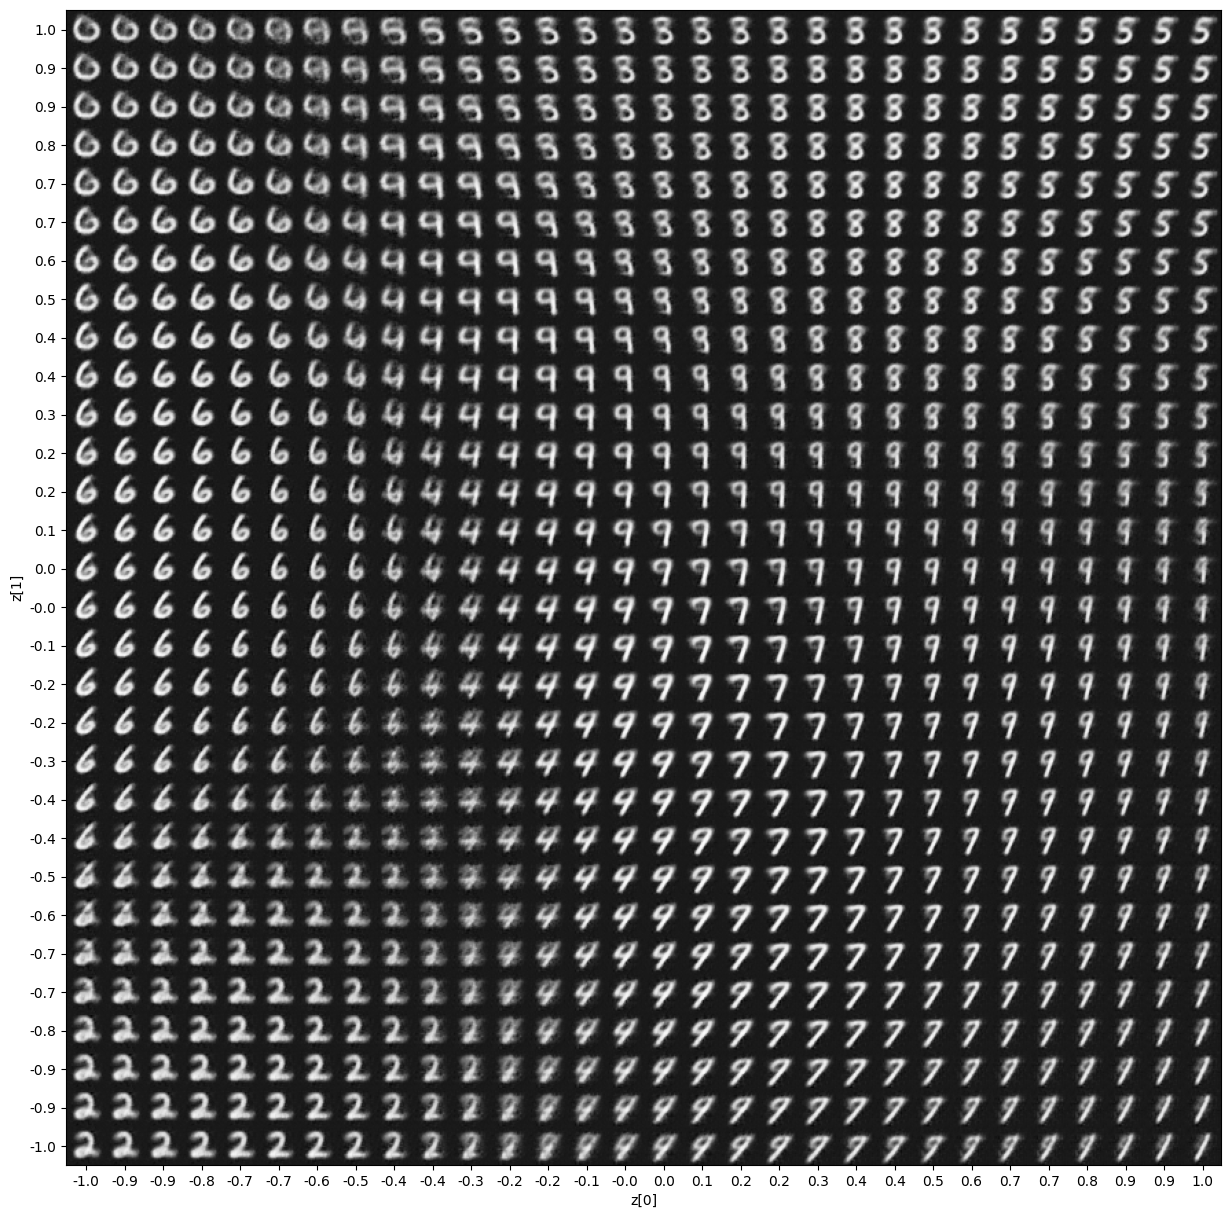

In [7]:
digit_size = 28
scale = 1.0
n = 30
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = np.linspace(-scale, scale, n)
grid_y = np.linspace(-scale, scale, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = torch.tensor([[xi, yi]]).to(device, dtype=torch.float)
        x_decoded = model.decoder(z_sample)
        digit = x_decoded[0].detach().cpu().numpy()
        figure[
            i * digit_size : (i + 1) * digit_size,
            j * digit_size : (j + 1) * digit_size,
        ] = digit

plt.figure(figsize=(15, 15))
start_range = digit_size // 2
end_range = n * digit_size + start_range
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x) 
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.imshow(figure, cmap="Greys_r")
plt.show()